In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import networkx as nx

from collections import defaultdict

import scipy.sparse as spsparse
import matplotlib.pylab as plt


import pyscisci.all as pyscisci


In [2]:
# set this path to where the MAG database is stored
path2mag = '/home/ajgates/MAG'
path2mag = '/users/hgt6rn/Documents/DataSets/MAG'

# apply a global filter to keep only journal articles
docfilter = pyscisci.DocTypeFilter(doctypes=['j'])

mymag = pyscisci.MAG(path2mag, database_extension='hdf', keep_in_memory=False,
                     global_filter = docfilter, show_progress=True) 
# set keep_in_memory=False if you want to load the database each time its needed 
# otherwise keep_in_memory=True will keep each database in memory after its loaded

# global_filter will only load publications that match the filtering criteria

In [3]:
# we will focus on a seminal paper that both measures and embodies interdisciplinarity:

# A general framework for analysing diversity in science, technology and society
# Andrew Stirling

focus_publication_id = 2110158660


# the idea here is to understand the interdisciplinary impact of the focus publication 

# to do this, we take all publications that cite the focus publication, and ask how these are related to eachother
# by making the co-citation network
# clusters/communities in this network reflect different home disciplines of the publications and 
# reflect the interdisciplinary nature of our original focus publication

In [4]:
# First we load all of the publications citing our focus publication
filter_dict = {'CitedPublicationId':np.sort([focus_publication_id])}
citing_focus = mymag.load_references(filter_dict=filter_dict)

focus_citing_pubs = np.sort(citing_focus['CitingPublicationId'].unique())

# Then we need all of the publications that cite these publications
pub2ref = mymag.load_references(filter_dict={'CitedPublicationId':focus_citing_pubs})

print("{0} citing publications produce {1} co-cited publications".format(pub2ref['CitingPublicationId'].nunique(), 
                                                                         pub2ref['CitedPublicationId'].nunique()) )

Loading pub2ref:   0%|          | 0/186 [00:00<?, ?it/s]

Loading pub2ref:   0%|          | 0/186 [00:00<?, ?it/s]

7403 citing publications produce 297 co-cited publications


In [5]:
# now lets get the field information

finfo = mymag.fieldinfo

# we'll take the fields at level 0
lvl0fields = finfo.loc[finfo['FieldLevel'] == 0][['FieldId', 'FieldName']]
fid2name = {fid:fname for fid, fname in lvl0fields.values}


# load the mapping of the publication to the fields

# we filter only for the publications (co-cited publications above)
# and level 0 fields
pub2field = mymag.load_pub2field(filter_dict={'PublicationId':np.sort(pub2ref['CitedPublicationId'].unique()), 
                                              'FieldId':np.sort(lvl0fields['FieldId'].unique())})


Loading Fields:   0%|          | 0/151 [00:00<?, ?it/s]

In [73]:
pubs_with_field = np.sort(pub2field['PublicationId'].values)
pub2ref = pub2ref.loc[pyscisci.isin_sorted(pub2ref['CitedPublicationId'].values, pubs_with_field)].copy()

pub2ref.nunique()

CitingPublicationId    6907
CitedPublicationId      280
dtype: int64

In [74]:
# we are going to make the co-citation network between all of the publications that cited our focus publication
cocitenet, cocite2int = pyscisci.cocitation_network(pub2ref, focus_pub_ids=focus_citing_pubs, 
                                        focus_constraint='cited', 
                                        temporal=False, show_progress=False)

# cocitenet is our network adjcency matrix
# cocite2int maps the publication ids to the row/col of the adjcency matrix
print("{0} nodes, and {1} edges".format(len(cocite2int), cocitenet.nnz))




280 nodes, and 2812 edges


In [75]:
# elminate self-loops
mat = cocitenet.copy()
mat.setdiag(0)

mat.data[mat.data <=1] = 0
mat.eliminate_zeros()

print(mat.nnz)

1290


In [76]:
n_components, labels = spsparse.csgraph.connected_components(mat)
print(n_components)
comidx, compsizes = np.unique(labels, return_counts=True)
print(max(compsizes))

lccidx = np.argmax(compsizes)

lcc = labels==lccidx
lccnodes = np.arange(mat.shape[0])[lcc]
remapnodes = {nid:i for i, nid in enumerate(lccnodes)}
cocite2int = {pid:remapnodes[i] for pid, i in cocite2int.items() if not remapnodes.get(i, None) is None}

lccmat = spsparse.coo_matrix(spsparse.csr_matrix(mat)[lcc][:,lcc])

153
123


In [77]:
cocite_pubs = np.sort(list(cocite2int.keys()))
cocite_fields = pub2field.loc[pyscisci.isin_sorted(pub2field['PublicationId'].values, cocite_pubs)].copy()

cocite_fields.nunique()

PublicationId    123
FieldId           12
dtype: int64

In [78]:
# most publications are mapped to multiple fields, even at level 1 
# to color our nodes, lets start by seeing which fields appear the most frequently
fieldcount = cocite_fields['FieldId'].value_counts(ascending=False)

for idx in fieldcount.index.values:
    print(idx, fid2name[idx], fieldcount.get(idx))
    
    

41008148 computer science 33
144024400 sociology 32
162324750 economics 20
144133560 business 12
33923547 mathematics 7
17744445 political science 6
205649164 geography 3
15744967 psychology 3
71924100 medicine 2
127413603 engineering 2
121332964 physics 2
86803240 biology 1


In [79]:
# we are going to take the largest 3 fields, and group together all of the remaining fields into an "other"
max_fields = 3
reorder_fields = {fid:i for i, fid in enumerate(fieldcount.index.values[:(max_fields+1)])}

cocite_fields['RemappedFields'] = [reorder_fields.get(fid, max_fields) for fid in cocite_fields['FieldId'].values]
cocite_fields.sort_values(by=['RemappedFields'], ascending=True, inplace=True)
cocite_fields.drop_duplicates(subset=['PublicationId'], keep='first', inplace=True)

cocite_fields.reset_index(inplace=True, drop=True)

In [80]:
fieldcount = cocite_fields['RemappedFields'].value_counts(ascending=False)
reorder_fields2 = {i:idx for idx, i in reorder_fields.items()}
for idx in fieldcount.index.values[:(max_fields+1)]:
    if idx < max_fields:
        print(idx, fid2name[reorder_fields2[idx]], fieldcount.get(idx))
        
print(max_fields, "other", fieldcount.get(max_fields))        

0 computer science 33
1 sociology 32
2 economics 20
3 other 38


In [81]:
#field2color = {0:'#DE9E36', 1:'#EF6461',4:'#C287E8',3:'#DFB2F4',2:'#87BFFF'}
field2color = {0:'#E9B44C', 1:'#50A2A7',2:'#8E5572', 3:'#5E8334'}
field2node = defaultdict(list)

for pid, fid in cocite_fields[['PublicationId', 'RemappedFields']].values:
    field2node[fid].append(cocite2int[pid])

# finally, one publication didnt have a field label
#field2node[3].append(96)

In [82]:
g = nx.Graph(lccmat)

pos = nx.drawing.nx_agraph.graphviz_layout(g, prog='sfdp')

0 33
1 32
2 20
3 38


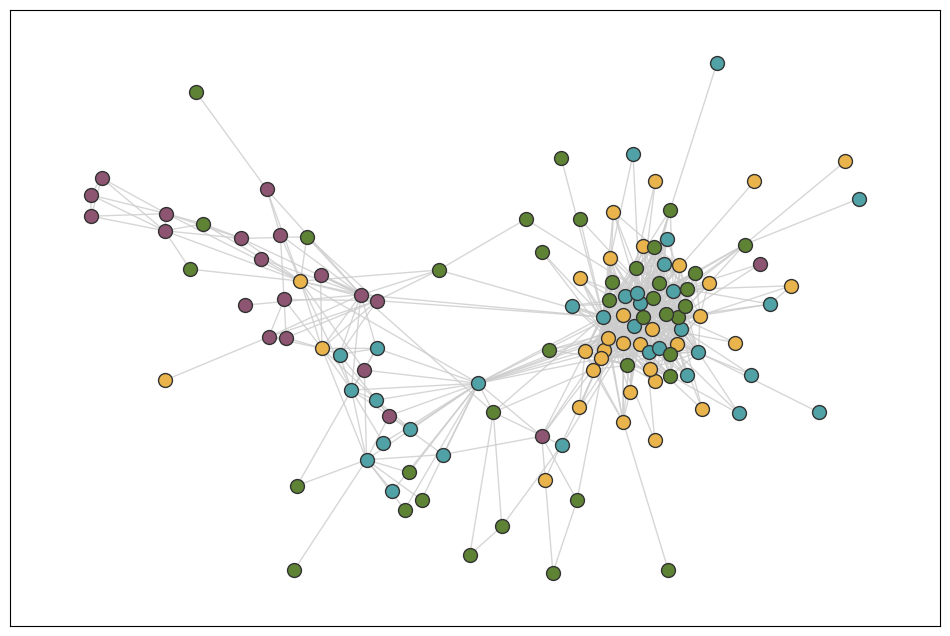

In [83]:
fig, ax = plt.subplots(1,1,figsize=(12,8))         



nx.draw_networkx_edges(g, pos, edgelist=g.edges(),
        edge_color = '0.8',
        alpha=0.8,
        ax=ax)

for fid in field2node.keys():
    print(fid, len(field2node[fid]))
    nx.draw_networkx_nodes(g.subgraph(field2node[fid]), pos,
        node_size= 100, 
        node_color=field2color[fid], 
        edgecolors='0.2', # node outline
                       vmax = 5,
        ax = ax)
    #print(fid, field2node[fid], len(g.subgraph(field2node[fid])))

#ax.set_facecolor('#09101F')

plt.savefig('StirlingCocitiation.pdf')
plt.show()

In [84]:
# we use cdlib to conduct community dectection in networks
# pip install cdlib
from cdlib import algorithms

# and then conduct similarity analysis using clusim
# pip install clusim
from clusim.clustering import Clustering, print_clustering
import clusim.sim as sim


coms = algorithms.louvain(g, weight='weight', resolution=1., randomize=False)

louvain_communities = Clustering().from_cluster_list(coms.communities)
field_communities = Clustering(clu2elm_dict = field2node)


print(louvain_communities.n_clusters, field_communities.n_clusters)
print(louvain_communities.n_elements, field_communities.n_elements)

print("Element-centric similarity: {}".format(sim.element_sim(louvain_communities, field_communities, alpha = 0.9)) )

elscore, _ = sim.element_sim_elscore(louvain_communities, field_communities, alpha = 0.9)

for c, elist in field2node.items():
    print(c, elscore[elist].mean())

4 4
123 123
Element-centric similarity: 0.3262145089174398
0 0.34856587263004374
1 0.30595128676470584
2 0.4542827794247672
3 0.2564635272391506


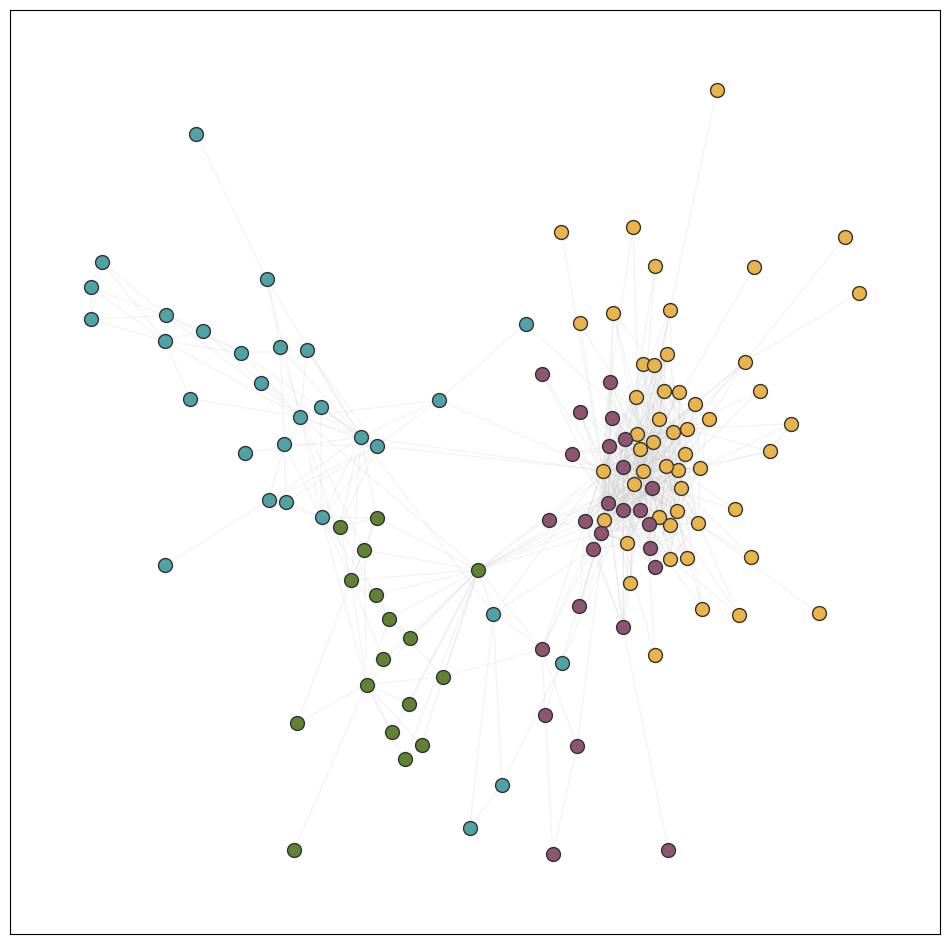

In [53]:
# draw the louvain clusters

fig, ax = plt.subplots(1,1,figsize=(12,12))         

nx.draw_networkx_edges(g, pos, edgelist=g.edges(),
        edge_color = '0.8',
        alpha=0.2,
        ax=ax)

for c in louvain_communities.clusters:
    nx.draw_networkx_nodes(g.subgraph(louvain_communities.clu2elm_dict[c]), pos,
        node_size= 100, 
        node_color=field2color[c], 
        edgecolors='0.2', # node outline
                       vmax = 5,
        ax = ax)
    #print(fid, field2node[c], len(g.subgraph(field2node[c])))

#ax.set_facecolor('#09101F')

#plt.savefig('DiversityCocitiation.pdf')
plt.show()

In [73]:
def estimate_resolution(G, com):
    """
    Newman, MEJ (2016) Community detection in networks: Modularity optimization and maximum likelihood are equivalent. Phy. Rev. E
    """
    m = G.number_of_edges()
    
    # eq 16
    kappas = [sum(deg for n, deg in G.degree(c)) for c in com.communities]
    m_in = [G.subgraph(c).number_of_edges() for c in com.communities]
    
    denom = np.sum(np.square(kappas)) / (2*m)
    
    # eq 17
    omega_in = 2*sum(m_in) / denom
    
    # eq 18
    omega_out = (2*m - 2*sum(m_in)) / (2*m - denom)
    
    # eq 15
    gamma = (omega_in - omega_out) / (np.log(omega_in) - np.log(omega_out))
    
    return gamma

estimate_resolution(g, coms)

1.0137403368935076

In [70]:
coms = algorithms.louvain(g, weight='weight', resolution=1.013, randomize=False)
estimate_resolution(g, coms)

1.0137403368935076